# Neural Machine Translation by Jointly Learning to Align and Translate

This notebook implements the model in:  
Bahdanau, D., Cho, K., and Bengio, Y. 2014. Neural machine translation by jointly learning to align and translate. arXiv preprint [arXiv:1409.0473](https://arxiv.org/abs/1409.0473).  

This model is based on an *Encoder-Decoder* framework, in which the encoder and the decoder are both RNNs.  
This model encodes all the information of the source sequence into the encoder's hidden states $\{h_1, h_2, \dots, h_{T_x} \}$, and allows the decoder (via an *attention mechanism*) to look at the entire hidden states in *every step* when generating the target sequence, instead of compressing all the information into a fixed-length context vector. This design aims to further relieve the *information compression*.  

![Learning to Align and Translate](fig/learning-to-align-and-translate.png)

In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

SEED = 515
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Preparing Data

In [2]:
import spacy
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

def tokenize_de(text):
    """
    Tokenize German text. 
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenize English text.
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [3]:
from torchtext.data import Field, BucketIterator

SRC = Field(tokenize=tokenize_de, init_token='<sos>', eos_token='<eos>', 
            lower=True, include_lengths=True)
TRG = Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>', 
            lower=True, include_lengths=True)

In [4]:
from torchtext.datasets import Multi30k

train_data, valid_data, test_data = Multi30k.splits(exts=['.de', '.en'], 
                                                    # fields=[SRC, TRG], 
                                                    fields=[('src', SRC), ('trg', TRG)], 
                                                    root="../assets/data")

In [5]:
print(train_data[0].src)
print(train_data[0].trg)

['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.']
['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']


In [6]:
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

len(SRC.vocab), len(TRG.vocab)

(7854, 5893)

In [7]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE, device=device)

In [8]:
for batch in train_iterator:
    batch_src, batch_src_lens = batch.src
    batch_trg, batch_trg_lens = batch.trg
    break
print(batch_src)
print(batch_src_lens)
print(batch_trg)
print(batch_trg_lens)

tensor([[  2,   2,   2,  ...,   2,   2,   2],
        [  5,   5,  43,  ...,   5,  18,  18],
        [ 13,  13, 253,  ...,  13,  30,   0],
        ...,
        [  1,   1,   1,  ...,   1,   1,   1],
        [  1,   1,   1,  ...,   1,   1,   1],
        [  1,   1,   1,  ...,   1,   1,   1]], device='cuda:0')
tensor([14, 17, 12, 11, 17, 21, 12, 16, 14, 11, 23, 23,  8, 11,  9, 14, 19, 20,
        12, 16,  9, 11, 13, 20, 21, 29, 13, 22, 14, 16, 10,  9, 15, 12, 17, 10,
        14, 22, 17, 20, 23, 23, 12, 17, 15, 19, 17, 15, 16,  7, 14, 15, 16, 12,
        17, 14, 18, 18, 14, 14, 17, 21, 12, 12,  9, 19, 12, 14, 12, 11, 10, 13,
        18, 14,  9, 11, 10, 12, 10, 25, 14, 18, 15, 16, 15, 18, 13,  9, 21, 11,
        20, 12, 13, 14, 14, 17, 10, 13, 18, 30, 14, 12, 13,  9, 10, 15, 13, 10,
        12, 15, 13, 18, 17, 13, 11, 12, 10, 16, 12, 13, 24, 14, 19, 19, 10, 20,
        12, 11], device='cuda:0')
tensor([[   2,    2,    2,  ...,    2,    2,    2],
        [   4,    4,   48,  ...,    4,   16,   

## Build Model
### Encoder
* Use GRU instead of LSTM.  
* Bidirectional GRU.  

In [9]:
class Encoder(nn.Module):
    def __init__(self, in_dim, emb_dim, enc_hid_dim, dec_hid_dim, n_layers, dropout, pad_idx):
        super().__init__()
        self.emb = nn.Embedding(in_dim, emb_dim, padding_idx=pad_idx)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, num_layers=n_layers, 
                          bidirectional=True, dropout=dropout)
        self.fc = nn.Linear(enc_hid_dim*2, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_lens):
        # src: (step, batch)
        embedded = self.dropout(self.emb(src))

        # Pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_lens, enforce_sorted=False)
        # hidden: (num_layers*num_directions, batch, hid_dim)
        packed_outs, hidden = self.rnn(packed_embedded)

        # outs: (step, batch, hid_dim*num_directions)
        outs, _ = nn.utils.rnn.pad_packed_sequence(packed_outs)

        # hidden: (num_layers, num_directions=2, batch, hid_dim)
        hidden = hidden.view(self.rnn.num_layers, 2, hidden.size(1), hidden.size(2))
        # hidden: (num_layers, batch, hid_dim*2)
        hidden = torch.cat([hidden[:, 0], hidden[:, 1]], dim=-1)
        # hidden: (num_layers, batch, dec_hid_dim)
        hidden = torch.tanh(self.fc(hidden))
        return outs, hidden

In [10]:
SRC_IN_DIM = len(SRC.vocab)
TRG_IN_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
ENC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
DEC_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

encoder = Encoder(SRC_IN_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, 
                  N_LAYERS, ENC_DROPOUT, ENC_PAD_IDX).to(device)
enc_outs, hidden = encoder(batch_src, batch_src_lens)

print(batch_src.size())
print(enc_outs.size())
print(hidden.size())

torch.Size([30, 128])
torch.Size([30, 128, 1024])
torch.Size([2, 128, 512])


### Attention
* Query: the last hidden state of the decoder
* Keys: the outputs of the encoder
* Values: the outputs of the encoder

In [11]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()

        self.proj = nn.Linear(enc_hid_dim*2 + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias=False)

    def forward(self, dec_outs, enc_outs, mask):
        """
        One-step forward. 
        """
        # enc_outs: (step, batch, enc_hid_dim*2)
        # dec_outs: (step=1, batch, dec_hid_dim)
        concated = torch.cat([enc_outs, dec_outs.repeat(enc_outs.size(0), 1, 1)], dim=-1)
        projected = torch.tanh(self.proj(concated))
        # energy: (step, batch)
        energy = self.v(projected).squeeze(-1)
        # Ignore the padding positions. 
        energy.masked_fill_(mask, -np.inf)
        return F.softmax(energy, dim=0)

In [12]:
attention = Attention(ENC_HID_DIM, DEC_HID_DIM).to(device)

# The `dec_outs` equals the hidden state at the top layer. 
mask = (batch_src == encoder.emb.padding_idx)
atten = attention(hidden[-1].unsqueeze(0), enc_outs, mask)

print(batch_src.size())
print(atten.size())

torch.Size([30, 128])
torch.Size([30, 128])


In [13]:
print(atten.sum(dim=0))
# Check the masked positions (i.e., padding positions).
print((atten == 0) == mask)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

### Decoder
* Use GRU instead of LSTM.  
* Combine the `embedding` and the `attentioned values` as the input to the RNN.  
* Combine the `embedding`, the (last layer) `hidden` and `attentioned values` as the input to the output FC. 

In [14]:
class Decoder(nn.Module):
    def __init__(self, in_dim, emb_dim, enc_hid_dim, dec_hid_dim, n_layers, dropout, pad_idx):
        super().__init__()
        self.emb = nn.Embedding(in_dim, emb_dim, padding_idx=pad_idx)
        self.attention = Attention(enc_hid_dim, dec_hid_dim)

        self.rnn = nn.GRU(emb_dim + enc_hid_dim*2, dec_hid_dim, num_layers=n_layers, dropout=dropout)
        # The output dimension equals the input dimension for the decoder.
        self.fc = nn.Linear(emb_dim + enc_hid_dim*2 + dec_hid_dim, in_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, hidden, enc_outs, mask):
        """
        One-step forward. 
        """
        # trg: (step=1, batch)
        # enc_outs: (step, batch, enc_hid_dim*2)
        embedded = self.dropout(self.emb(trg))

        # atten: (step, batch)
        atten = self.attention(hidden[-1].unsqueeze(0), enc_outs, mask)

        # (batch, enc_hid_dim*2, step) * (batch, step, 1) -> (batch, enc_hid_dim*2, 1)
        attened_values = enc_outs.permute(1, 2, 0).bmm(atten.T.unsqueeze(-1))
        # attened_values: (1, batch, enc_hid_dim*2)
        attened_values = attened_values.permute(2, 0, 1)

        # outs: (step=1, batch, dec_hid_dim)
        # hidden: (num_layers*num_directions, batch, dec_hid_dim)
        outs, hidden = self.rnn(torch.cat([embedded, attened_values], dim=-1), 
                                hidden)
        # preds: (step=1, batch, out_dim=in_dim)
        preds = self.fc(torch.cat([embedded, outs, attened_values], dim=-1))
        return preds, hidden, atten

In [15]:
decoder = Decoder(TRG_IN_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, 
                  N_LAYERS, DEC_DROPOUT, DEC_PAD_IDX).to(device)

preds, hidden, atten = decoder(batch_trg[0].unsqueeze(0), hidden, enc_outs, mask)

print(batch_trg.size())
print(preds.size())
print(hidden.size())

torch.Size([29, 128])
torch.Size([1, 128, 5893])
torch.Size([2, 128, 512])


### Seq2Seq

In [16]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, src_lens, trg, teacher_forcing_ratio=0.5):
        # src: (step, batch)
        # trg: (step, batch)
        enc_outs, hidden = self.encoder(src, src_lens)
        mask = (src == self.encoder.emb.padding_idx)

        preds = []
        attens = []
        # The first input to the decoder is the <sos> token. 
        # trg_t: (step=1, batch)
        trg_t = trg[0].unsqueeze(0)
        for t in range(1, trg.size(0)):
            # preds_t: (step=1, batch, trg_out_dim)
            # atten_t: (enc_step, batch)
            preds_t, hidden, atten_t = self.decoder(trg_t, hidden, enc_outs, mask)

            # top1: (step=1, batch)
            top1 = preds_t.argmax(dim=-1)
            if np.random.rand() < teacher_forcing_ratio:
                trg_t = trg[t].unsqueeze(0)
            else:
                trg_t = top1
            preds.append(preds_t)
            attens.append(atten_t.unsqueeze(0))
        # preds: (step-1, batch, trg_out_dim)
        # attens: (step-1, enc_step, batch)
        return torch.cat(preds, dim=0), torch.cat(attens, dim=0)

    def translate(self, src, src_lens, sos: int, trg_max_len: int=50):
        # Ensure `dropout` off, or the result would change randomly. 
        self.eval()
        # Create an pseudo target sequence. 
        pseudo_trg = torch.ones(trg_max_len, src.size(1), 
                                dtype=torch.long, device=src.device) * sos
        preds, attens = self(src, src_lens, pseudo_trg, teacher_forcing_ratio=0)
        return preds.argmax(dim=-1), attens

In [17]:
model = Seq2Seq(encoder, decoder).to(device)
preds, attens = model(batch_src, batch_src_lens, batch_trg)

print(batch_trg.size())
print(preds.size())
print(attens.size())

torch.Size([29, 128])
torch.Size([28, 128, 5893])
torch.Size([28, 30, 128])


In [18]:
DEC_SOS_IDX = TRG.vocab.stoi[TRG.init_token]
DEC_EOS_IDX = TRG.vocab.stoi[TRG.eos_token]
pred_indexes, attens = model.translate(batch_src, batch_src_lens, DEC_SOS_IDX)

print(pred_indexes.size())
print(attens.size())

torch.Size([49, 128])
torch.Size([49, 30, 128])


## Train Model

In [19]:
def init_weights(m: nn.Module):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

N_LAYERS = 1
encoder = Encoder(SRC_IN_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, 
                  N_LAYERS, ENC_DROPOUT, ENC_PAD_IDX)
decoder = Decoder(TRG_IN_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, 
                  N_LAYERS, DEC_DROPOUT, DEC_PAD_IDX)
model = Seq2Seq(encoder, decoder).to(device)

model.apply(init_weights)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 20,518,661 trainable parameters


In [20]:
# Initialize Embeddings 
ENC_UNK_IDX = SRC.vocab.stoi[SRC.unk_token]
DEC_UNK_IDX = TRG.vocab.stoi[TRG.unk_token]

model.encoder.emb.weight.data[ENC_UNK_IDX].zero_()
model.encoder.emb.weight.data[ENC_PAD_IDX].zero_()
model.decoder.emb.weight.data[DEC_UNK_IDX].zero_()
model.decoder.emb.weight.data[DEC_PAD_IDX].zero_()

print(model.encoder.emb.weight[:5, :8])
print(model.decoder.emb.weight[:5, :8])

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-4.5238e-03,  1.4508e-03, -9.9096e-03,  6.5350e-03,  5.8116e-03,
          1.2935e-02, -7.2838e-03,  7.9034e-05],
        [-1.5500e-02,  1.6991e-03,  3.9914e-03,  1.8100e-02, -1.2051e-02,
         -1.4182e-03, -3.5701e-03, -5.3757e-03],
        [-7.6994e-03, -7.2831e-03,  8.9148e-03,  2.0916e-03, -1.6530e-03,
          3.9528e-03,  9.3621e-03,  1.3413e-02]], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-1.5861e-04,  9.4898e-03,  8.5254e-03,  1.7641e-03,  5.5870e-03,
         -8.477

In [21]:
loss_func = nn.CrossEntropyLoss(ignore_index=DEC_PAD_IDX, reduction='mean')
optimizer = optim.AdamW(model.parameters())

We must ensure we turn `teacher forcing` off for evaluation. This will cause the model to only use it's own predictions to make further predictions within a sentence, which mirrors how it would be used in deployment. 

In [22]:
def train_epoch(model, iterator, optimizer, loss_func, clip):
    model.train()
    epoch_loss = 0
    for batch in iterator:
        # Forward pass
        batch_src, batch_src_lens = batch.src
        batch_trg, batch_trg_lens = batch.trg
        # preds: (step-1, batch, trg_out_dim)
        preds, _ = model(batch_src, batch_src_lens, batch_trg)
        
        # Calculate loss
        preds_flattened = preds.view(-1, preds.size(-1))
        batch_trg_flattened = batch_trg[1:].flatten()
        loss = loss_func(preds_flattened, batch_trg_flattened)

        # Backward propagation
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)

        # Update weights
        optimizer.step()
        # Accumulate loss
        epoch_loss += loss.item()
    return epoch_loss/len(iterator)

def eval_epoch(model, iterator, loss_func):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch in iterator:
            # Forward pass
            batch_src, batch_src_lens = batch.src
            batch_trg, batch_trg_lens = batch.trg
            # preds: (step-1, batch, trg_out_dim)
            preds, _ = model(batch_src, batch_src_lens, batch_trg, teacher_forcing_ratio=0)
            
            # Calculate loss
            preds_flattened = preds.view(-1, preds.size(-1))
            batch_trg_flattened = batch_trg[1:].flatten()
            loss = loss_func(preds_flattened, batch_trg_flattened)
            
            # Accumulate loss and acc
            epoch_loss += loss.item()
    return epoch_loss/len(iterator)

In [23]:
import time
N_EPOCHS = 10
CLIP = 1
best_valid_loss = np.inf

for epoch in range(N_EPOCHS):
    t0 = time.time()
    train_loss = train_epoch(model, train_iterator, optimizer, loss_func, CLIP)
    valid_loss = eval_epoch(model, valid_iterator, loss_func)
    epoch_secs = time.time() - t0

    epoch_mins, epoch_secs = int(epoch_secs // 60), int(epoch_secs % 60)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "models/tut3-model.pt")
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {np.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {np.exp(valid_loss):7.3f}')

Epoch: 01 | Epoch Time: 0m 35s
	Train Loss: 5.028 | Train PPL: 152.565
	 Val. Loss: 4.726 |  Val. PPL: 112.865
Epoch: 02 | Epoch Time: 0m 34s
	Train Loss: 4.037 | Train PPL:  56.668
	 Val. Loss: 4.030 |  Val. PPL:  56.240
Epoch: 03 | Epoch Time: 0m 34s
	Train Loss: 3.317 | Train PPL:  27.586
	 Val. Loss: 3.516 |  Val. PPL:  33.660
Epoch: 04 | Epoch Time: 0m 33s
	Train Loss: 2.805 | Train PPL:  16.526
	 Val. Loss: 3.371 |  Val. PPL:  29.103
Epoch: 05 | Epoch Time: 0m 33s
	Train Loss: 2.472 | Train PPL:  11.845
	 Val. Loss: 3.264 |  Val. PPL:  26.164
Epoch: 06 | Epoch Time: 0m 33s
	Train Loss: 2.217 | Train PPL:   9.184
	 Val. Loss: 3.206 |  Val. PPL:  24.689
Epoch: 07 | Epoch Time: 0m 32s
	Train Loss: 1.992 | Train PPL:   7.329
	 Val. Loss: 3.192 |  Val. PPL:  24.328
Epoch: 08 | Epoch Time: 0m 33s
	Train Loss: 1.801 | Train PPL:   6.054
	 Val. Loss: 3.198 |  Val. PPL:  24.485
Epoch: 09 | Epoch Time: 0m 34s
	Train Loss: 1.654 | Train PPL:   5.229
	 Val. Loss: 3.239 |  Val. PPL:  25.519
E

In [24]:
model.load_state_dict(torch.load("models/tut3-model.pt", map_location=device))

valid_loss = eval_epoch(model, valid_iterator, loss_func)
test_loss = eval_epoch(model, test_iterator, loss_func)

print(f'Val. Loss: {valid_loss:.3f} |  Val. PPL: {np.exp(valid_loss):7.3f}')
print(f'Test Loss: {test_loss:.3f} |  Test PPL: {np.exp(test_loss):7.3f}')

Val. Loss: 3.192 |  Val. PPL:  24.328
Test Loss: 3.174 |  Test PPL:  23.910


## Check Embeddings
* The Embeddings of `<unk>` and `<pad>` tokens
    * Because the `padding_idx` has been passed to `nn.Embedding`, so the `<pad>` embedding will remain zeros throughout training.  
    * While the `<unk>` embedding will be learned.

In [25]:
print(model.encoder.emb.weight[:5, :8])
print(model.decoder.emb.weight[:5, :8])

tensor([[ 0.0017, -0.0017, -0.0098,  0.0370, -0.0312, -0.0238, -0.0087, -0.0236],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0003, -0.0293, -0.0421,  0.0201,  0.0824,  0.0848,  0.0090, -0.0376],
        [-0.0269,  0.0005, -0.0045,  0.0394, -0.0372,  0.0254,  0.0050, -0.0782],
        [-0.0175,  0.0093,  0.0181,  0.0127,  0.0166,  0.0148,  0.0201, -0.0204]],
       device='cuda:0', grad_fn=<SliceBackward>)
tensor([[ 0.0828, -0.0186, -0.0013,  0.0190, -0.0120, -0.0430,  0.0698,  0.0385],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.1213,  0.1157,  0.1057,  0.1350,  0.1575,  0.0735,  0.1333, -0.1032],
        [ 0.0888,  0.0206,  0.0133, -0.0865, -0.0892,  0.0636, -0.0304, -0.0781],
        [ 0.0365, -0.0598,  0.0219,  0.0350,  0.0498, -0.0173,  0.0465,  0.1127]],
       device='cuda:0', grad_fn=<SliceBackward>)


## Inference

In [26]:
def translate(model, src_tokens):
    """
    Single sentence translation.
    """
    model.eval()
    src_indexes = [SRC.vocab.stoi[tok] for tok in src_tokens]
    src = torch.tensor(src_indexes, dtype=torch.long, device=device).unsqueeze(1)
    src_lens = torch.tensor([len(src_indexes)], dtype=torch.long, device=device)

    with torch.no_grad():
        # pred_indexes: (trg_step-1, batch)
        # attens: (trg_step-1, src_step, batch)
        pred_indexes, attens = model.translate(src, src_lens, DEC_SOS_IDX)

    trans_tokens = []
    for idx in pred_indexes.flatten():
        tok = TRG.vocab.itos[idx.item()]
        trans_tokens.append(tok)
        if tok == TRG.eos_token:
            break
    return trans_tokens, attens[:len(trans_tokens)].squeeze(-1)

In [27]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def plot_attention(src_tokens, trans_tokens, attens):
    """
    For each translated token, the associated attention is the attention for predicting 
    the translated token. 
    """
    fig, ax = plt.subplots()
    ax.matshow(attens, cmap='bone')
    ax.set_xticklabels([""] + src_tokens, rotation=90)
    ax.set_yticklabels([""] + trans_tokens)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()
    plt.close()

<sos> zwei junge weiße männer sind im freien in der nähe vieler büsche . <eos>
two young white white males are outside near bushes . <eos>
two young , white males are outside near many bushes .


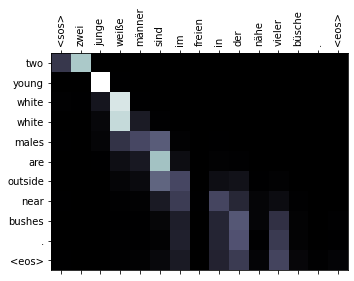

In [28]:
ex_idx = 0
src_tokens = train_data[ex_idx].src
trg_tokens = train_data[ex_idx].trg
src_tokens = [SRC.init_token] + src_tokens + [SRC.eos_token]
trans_tokens, attens = translate(model, src_tokens)
attens = (attens.cpu().numpy() if attens.device.type == 'cuda' else attens.numpy())

print(" ".join(src_tokens))
print(" ".join(trans_tokens))
print(" ".join(trg_tokens))

plot_attention(src_tokens, trans_tokens, attens)

<sos> mehrere männer mit schutzhelmen bedienen ein antriebsradsystem . <eos>
several men wearing hard hats are operating a pulley pulley . <eos>
several men in hard hats are operating a giant pulley system .


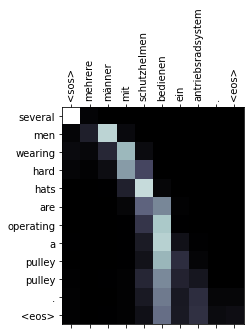

In [29]:
ex_idx = 1
src_tokens = train_data[ex_idx].src
trg_tokens = train_data[ex_idx].trg
src_tokens = [SRC.init_token] + src_tokens + [SRC.eos_token]
trans_tokens, attens = translate(model, src_tokens)
attens = (attens.cpu().numpy() if attens.device.type == 'cuda' else attens.numpy())

print(" ".join(src_tokens))
print(" ".join(trans_tokens))
print(" ".join(trg_tokens))

plot_attention(src_tokens, trans_tokens, attens)

<sos> ein kleines mädchen klettert in ein spielhaus aus holz . <eos>
a young girl climbing climbing a playhouse playhouse . <eos>
a little girl climbing into a wooden playhouse .


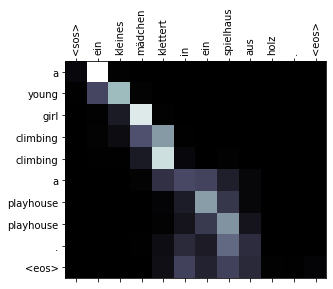

In [30]:
ex_idx = 2
src_tokens = train_data[ex_idx].src
trg_tokens = train_data[ex_idx].trg
src_tokens = [SRC.init_token] + src_tokens + [SRC.eos_token]
trans_tokens, attens = translate(model, src_tokens)
attens = (attens.cpu().numpy() if attens.device.type == 'cuda' else attens.numpy())

print(" ".join(src_tokens))
print(" ".join(trans_tokens))
print(" ".join(trg_tokens))

plot_attention(src_tokens, trans_tokens, attens)

<sos> ein mann in einem blauen hemd steht auf einer leiter und putzt ein fenster . <eos>
a man in a blue shirt is standing on a ladder and a a window . <eos>
a man in a blue shirt is standing on a ladder cleaning a window .


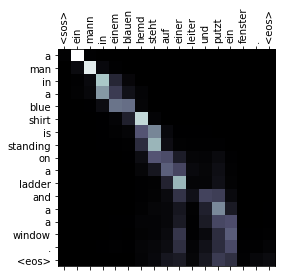

In [31]:
ex_idx = 3
src_tokens = train_data[ex_idx].src
trg_tokens = train_data[ex_idx].trg
src_tokens = [SRC.init_token] + src_tokens + [SRC.eos_token]
trans_tokens, attens = translate(model, src_tokens)
attens = (attens.cpu().numpy() if attens.device.type == 'cuda' else attens.numpy())

print(" ".join(src_tokens))
print(" ".join(trans_tokens))
print(" ".join(trg_tokens))

plot_attention(src_tokens, trans_tokens, attens)

## BLEU

*BLEU* (Bilingual Evaluation Understudy) is a metric measuring the quality of translation.  
BLEU looks at the overlap in the predicted and actual target sequences in terms of their *n-grams*.  
BLEU gives a number between 0 and 1 for each sequence, and a higher BLEU suggests better translation quality.  
BLEU being 1 means a perfect overlap, i.e., a perfect translation.  

In [32]:
from torchtext.data.metrics import bleu_score

def calc_bleu(data):
    trg_data = []
    trans_data = []
    for ex in data:
        src_tokens = ex.src
        trg_tokens = ex.trg
        src_tokens = [SRC.init_token] + src_tokens + [SRC.eos_token]
        trans_tokens, attens = translate(model, src_tokens)

        # The groudtruth may contain multiple actual sentences (right translations). 
        trg_data.append([trg_tokens])
        trans_data.append(trans_tokens[:-1])  # Cut off the <eos> token

    return bleu_score(trans_data, trg_data)

In [33]:
bleu = calc_bleu(test_data)

print(f'BLEU score is: {bleu*100:.2f}')

BLEU score is: 30.73
